In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import sys


import torch
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as utils
import torchvision
from torchvision import datasets, models, transforms
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)

from albumentations.pytorch import ToTensorV2

from efficientnet_pytorch import EfficientNet
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
import warnings
warnings.filterwarnings("ignore")

In [14]:
BASE_DIR = "../../../data/cassava-leaf-disease-classification"
train_dir = os.path.join(BASE_DIR, 'train_images/')
test_dir = os.path.join(BASE_DIR, "test_images/")
print(train_dir)

../../../data/cassava-leaf-disease-classification\train_images/


In [15]:
#日付を取得
import datetime as dt

dt_now = dt.datetime.now()
directory_name = dt_now.strftime('%Y%m%d%H')
create_directory = BASE_DIR + '/models/' + directory_name
if(not (os.path.exists(create_directory))):
    os.mkdir(create_directory)

In [16]:
## config
class CFG:
    num_workers=0
    model_name='efficientnet-b3'
    size=300
    batch_size=8
    target_size=5
    target_col='label'
    n_fold=3
    seed = 2021
    learning_rate = 1e-5
    num_epochs = 20
    n_split = 3
    checkpoint_thres_loss = 0.5
    checkpoint_thres_acc = 80
    weights=torch.tensor([1.5, 1.0, 1.0, 1.0, 1.0]) #see 000_EDA.ipynb
    weight_decay=1e-6

In [17]:
np.random.seed(CFG.seed)
random.seed(CFG.seed)
torch.manual_seed(CFG.seed)
torch.cuda.manual_seed(CFG.seed)

In [18]:
df_train = pd.read_csv(BASE_DIR + "/train.csv")
df_train.head()


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [19]:

model = EfficientNet.from_pretrained(CFG.model_name)
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, CFG.target_size)

Loaded pretrained weights for efficientnet-b3


In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

cuda:0
GeForce RTX 2060
Memory Usage:
Allocated: 0.2 GB
Cached:    2.9 GB


In [9]:
def get_train_transforms():
    return Compose([
            RandomResizedCrop(CFG.size, CFG.size),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            CoarseDropout(p=0.5),
            Cutout(p=0.5),
            ToTensorV2(p=1.0),
        ], p=1.)
  
        
def get_valid_transforms():
    return Compose([
            CenterCrop(CFG.size, CFG.size, p=1.),
            Resize(CFG.size, CFG.size),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

In [10]:
class ImageData(Dataset):
    def __init__(self, df, data_dir, transform, output_label=True):
        super().__init__()
        self.df = df
        self.data_dir = data_dir
        self.transform = transform
        self.output_label = output_label

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):       
        img_name = self.df.iloc[index,0]
        if self.output_label:
            label = self.df.iloc[index,1]
        
        img_path = os.path.join(self.data_dir, img_name)
        image = plt.imread(img_path)
        image = self.transform(image=image)

        # do label smoothing
        if self.output_label == True:
            return image, label
        else:
            return image

In [11]:
def Plot_Model_History(loss_tra_li,acc_tra_li,loss_val_li,acc_val_li):
    plt.figure(figsize=(12, 5))
    plt.subplot(2, 2, 1)
    plt.plot(loss_tra_li, label="train_loss")
    plt.plot(loss_val_li, label="val_loss")
    plt.legend()
    plt.subplot(2, 2, 2)
    plt.plot(acc_tra_li, label="train_acc")
    plt.plot(acc_val_li, label="val_acc")
    plt.legend()
    plt.show()
    
def Save_histroy(init=False):
    filename = "./log/" + directory_name
    if init:
        with open(filename+'.txt','w') as f:
            f.write("model: {}, lr: {}, weights: {}. batchsize: {}, kfold: {}, epoch: {}, weght_decay: {},\n" 
            .format(CFG.model_name,CFG.learning_rate,CFG.weights, CFG.batch_size,CFG.n_split,CFG.num_epochs,CFG.weight_decay))
    else:
        with open(filename+'.txt',mode='a') as f:
            f.write('\nkfold: {}, epoch: {}. train_loss: {}, train_acc: {}. val_loss: {}, val_acc: {}'
                    .format(fold_index+1, epoch + 1, train_loss, train_acc, val_loss, val_acc))
            
            
            
def Confusion_Matrix(train_true_li,train_pred_li,val_true_li,val_pred_li):
    plt.figure(figsize=(10,5))
    train_cm = confusion_matrix(train_true_li,train_pred_li)
    val_cm = confusion_matrix(val_true_li,val_pred_li)
    plt.subplot(1,2,1)
    sns.heatmap(train_cm, annot=True, cmap='Blues', cbar=False)
    plt.xlabel("taget")
    plt.ylabel("predict")
    plt.title("train")
    
    plt.subplot(1,2,2)
    sns.heatmap(val_cm, annot=True, cmap='Blues', cbar=False)
    plt.title("val")
    plt.xlabel("taget")
    plt.ylabel("predict")
    plt.show()

Loaded pretrained weights for efficientnet-b3
Kfold: 1 - Epoch: 1 - Train_Loss: 1.031698 - Train_Acc: 64.7084 - Val_Loss: 0.906301 - Val_Acc: 70.979952
Kfold: 1 - Epoch: 2 - Train_Loss: 0.758225 - Train_Acc: 73.7801 - Val_Loss: 0.728569 - Val_Acc: 75.774569
Kfold: 1 - Epoch: 3 - Train_Loss: 0.666219 - Train_Acc: 76.8859 - Val_Loss: 0.642298 - Val_Acc: 78.438245
Kfold: 1 - Epoch: 4 - Train_Loss: 0.614608 - Train_Acc: 78.6946 - Val_Loss: 0.588612 - Val_Acc: 80.372915
Kfold: 1 - Epoch: 5 - Train_Loss: 0.584841 - Train_Acc: 79.7953 - Val_Loss: 0.572585 - Val_Acc: 80.751437
Kfold: 1 - Epoch: 6 - Train_Loss: 0.567650 - Train_Acc: 80.4403 - Val_Loss: 0.562648 - Val_Acc: 80.765456
Kfold: 1 - Epoch: 7 - Train_Loss: 0.545044 - Train_Acc: 81.3657 - Val_Loss: 0.540470 - Val_Acc: 81.704753
Kfold: 1 - Epoch: 8 - Train_Loss: 0.526307 - Train_Acc: 82.2070 - Val_Loss: 0.520461 - Val_Acc: 82.644049
Kfold: 1 - Epoch: 9 - Train_Loss: 0.515291 - Train_Acc: 82.3542 - Val_Loss: 0.533125 - Val_Acc: 81.788869


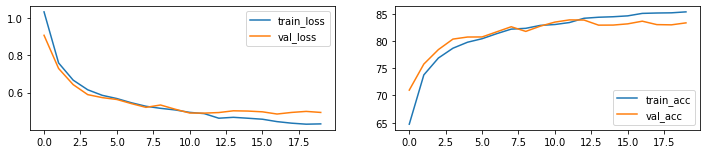

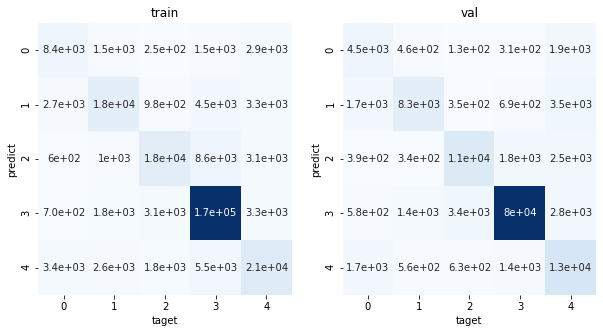

Loaded pretrained weights for efficientnet-b3
Kfold: 2 - Epoch: 1 - Train_Loss: 1.039293 - Train_Acc: 64.2902 - Val_Loss: 0.882503 - Val_Acc: 71.074033
Kfold: 2 - Epoch: 2 - Train_Loss: 0.764675 - Train_Acc: 73.4175 - Val_Loss: 0.694847 - Val_Acc: 77.257431
Kfold: 2 - Epoch: 3 - Train_Loss: 0.666391 - Train_Acc: 76.8945 - Val_Loss: 0.612432 - Val_Acc: 79.332586
Kfold: 2 - Epoch: 4 - Train_Loss: 0.626186 - Train_Acc: 78.4718 - Val_Loss: 0.573170 - Val_Acc: 80.356141
Kfold: 2 - Epoch: 5 - Train_Loss: 0.594859 - Train_Acc: 79.4182 - Val_Loss: 0.558045 - Val_Acc: 81.127314
Kfold: 2 - Epoch: 6 - Train_Loss: 0.577380 - Train_Acc: 80.1823 - Val_Loss: 0.546357 - Val_Acc: 81.646102
Kfold: 2 - Epoch: 7 - Train_Loss: 0.550626 - Train_Acc: 81.0866 - Val_Loss: 0.541676 - Val_Acc: 81.758273
Kfold: 2 - Epoch: 8 - Train_Loss: 0.538071 - Train_Acc: 81.7175 - Val_Loss: 0.538843 - Val_Acc: 81.688166
Kfold: 2 - Epoch: 9 - Train_Loss: 0.522113 - Train_Acc: 82.0820 - Val_Loss: 0.526661 - Val_Acc: 82.094784


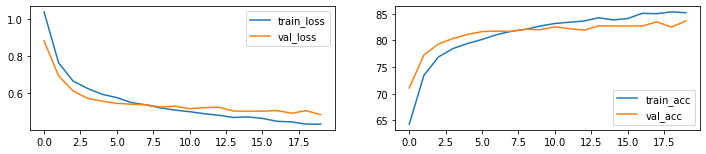

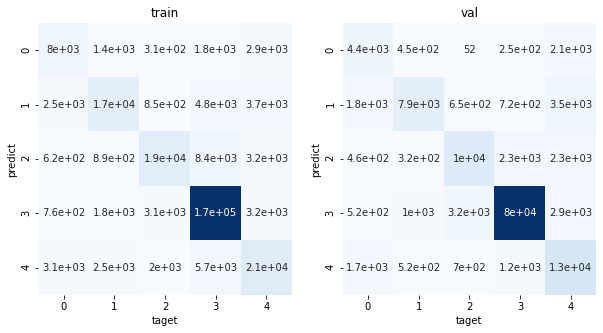

Loaded pretrained weights for efficientnet-b3
Kfold: 3 - Epoch: 1 - Train_Loss: 1.027427 - Train_Acc: 64.3743 - Val_Loss: 0.906932 - Val_Acc: 70.471116
Kfold: 3 - Epoch: 2 - Train_Loss: 0.776931 - Train_Acc: 73.3824 - Val_Loss: 0.712234 - Val_Acc: 76.598430
Kfold: 3 - Epoch: 3 - Train_Loss: 0.670329 - Train_Acc: 77.2100 - Val_Loss: 0.645157 - Val_Acc: 78.309030
Kfold: 3 - Epoch: 4 - Train_Loss: 0.622196 - Train_Acc: 78.8363 - Val_Loss: 0.589817 - Val_Acc: 79.963545
Kfold: 3 - Epoch: 5 - Train_Loss: 0.590944 - Train_Acc: 79.8107 - Val_Loss: 0.563333 - Val_Acc: 80.664610
Kfold: 3 - Epoch: 6 - Train_Loss: 0.563348 - Train_Acc: 81.0375 - Val_Loss: 0.535221 - Val_Acc: 81.968592
Kfold: 3 - Epoch: 7 - Train_Loss: 0.547165 - Train_Acc: 81.1497 - Val_Loss: 0.513080 - Val_Acc: 82.206955
Kfold: 3 - Epoch: 8 - Train_Loss: 0.538596 - Train_Acc: 81.1987 - Val_Loss: 0.494274 - Val_Acc: 83.258553
Kfold: 3 - Epoch: 9 - Train_Loss: 0.521709 - Train_Acc: 82.3274 - Val_Loss: 0.494861 - Val_Acc: 83.258553


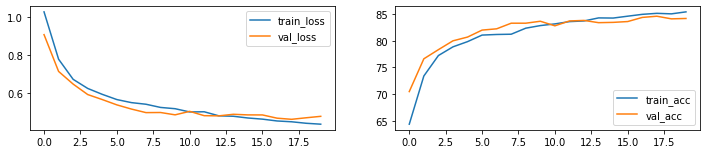

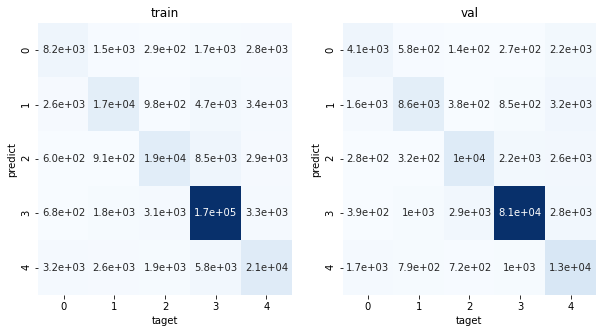

In [12]:
# n_splitsでKの数を指定
folds = StratifiedKFold(n_splits=CFG.n_split).split(np.arange(df_train.shape[0]), df_train["label"].values)
Save_histroy(init=True)
for fold_index, (train_index,val_index) in enumerate(folds):
    model = EfficientNet.from_pretrained(CFG.model_name)
    num_ftrs = model._fc.in_features
    model._fc = nn.Linear(num_ftrs, CFG.target_size)
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=CFG.learning_rate)
    
    train = df_train.iloc[train_index].reset_index(drop=True)
    train_data = ImageData(df = train, data_dir = train_dir, transform = get_train_transforms())
    train_loader = DataLoader(dataset = train_data, batch_size = CFG.batch_size, num_workers=CFG.num_workers, pin_memory=True,shuffle=True)
    train_criterion = nn.CrossEntropyLoss(weight=CFG.weights).to(device)
    
    val = df_train.iloc[val_index,:].reset_index(drop=True)
    val_data = ImageData(df = val, data_dir = train_dir, transform = get_valid_transforms())
    val_loader = DataLoader(dataset = val_data, batch_size = CFG.batch_size, num_workers=CFG.num_workers, pin_memory=True,shuffle=True)
    val_criterion = nn.CrossEntropyLoss(weight=CFG.weights).to(device)
    train_epoch_log = []
    train_acc_log = []
    val_epoch_log = []
    val_acc_log = []
    train_taget_li = []
    train_pred_li = []
    val_taget_li = []
    val_pred_li = []
    for epoch in range(CFG.num_epochs):
        train_total = 0
        train_correct = 0
        train_loss_sum = 0
        val_total = 0
        val_correct = 0
        val_loss_sum = 0
        
        # train
        model.train()
        for idx, (data, target) in enumerate(train_loader):
            data, target = data['image'].to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = train_criterion(output, target)
            loss.backward()
            optimizer.step()  
            
            train_loss_sum += loss.item()
            train_total += target.size(0)
            _,predicted = output.max(1)
            train_correct += predicted.eq(target).sum().item()
            train_taget_li.extend(target.to('cpu').detach().numpy().copy().tolist())
            train_pred_li.extend(predicted.to('cpu').detach().numpy().copy().tolist())
            
            
        train_loss = train_loss_sum / len(train_loader)
        train_epoch_log.append(train_loss)
        train_acc = 100.0 * train_correct/train_total
        train_acc_log.append(train_acc)
        
        # val
        model.eval()
        with torch.no_grad():
            for idx, (data, target) in enumerate(val_loader):
                data, target = data['image'].to(device), target.to(device)
                output = model(data)
                loss = val_criterion(output, target)
                val_loss_sum += loss.item()
                val_total += target.size(0)
                _,predicted = output.max(1)
                val_correct += (predicted == target).sum().item()
                val_taget_li.extend(target.to('cpu').detach().numpy().copy().tolist())
                val_pred_li.extend(predicted.to('cpu').detach().numpy().copy().tolist())
                    
            val_loss = val_loss_sum / len(val_loader)
            val_epoch_log.append(val_loss)
            val_acc = 100.0 * val_correct/val_total
            val_acc_log.append(val_acc)
                
        print('Kfold: {} - Epoch: {} - Train_Loss: {:.6f} - Train_Acc: {:.4f} - Val_Loss: {:.6f} - Val_Acc: {:4f}'.format(fold_index+1, epoch + 1, train_loss, train_acc, val_loss, val_acc))
        Save_histroy(init=False)
        if (val_loss < CFG.checkpoint_thres_loss) & (val_acc > CFG.checkpoint_thres_acc):
            CFG.checkpoint_thres_loss = val_loss
            CFG.checkpoint_thres_acc = val_acc
            path = create_directory + "./"+ CFG.model_name + "epoch"+str(epoch)+ "_Acc_" + str(val_acc) + '.pth'
            torch.save(model.state_dict(), path) 
        
    Plot_Model_History(train_epoch_log,train_acc_log,val_epoch_log,val_acc_log)
    Confusion_Matrix(train_taget_li,train_pred_li,val_taget_li,val_pred_li)